1. Cargamos el archivo A1.5 Calificaciones.csv al ambiente de trabajo y revisamos el tipo de dato de cada variable.  Este paso es importante porque conocer los tipos de datos (numéricos, categóricos, etc.) nos permite decidir qué transformaciones serán necesarios más adelante.

In [1]:
import pandas as pd #Importamos librería
datos=pd.read_csv("A1.5 Calificaciones.csv") #Leer archivo
print("Tipos de variables en el DataFrame:")
print(datos.dtypes) #Con dtypes nos da los tipos de variables
print("Ejemplos de fila del dataframe")
print(datos.head(5))

Tipos de variables en el DataFrame:
Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object
Ejemplos de fila del dataframe
  Escuela Sexo  Edad  HorasDeEstudio  Reprobadas Internet  Faltas  G1  G2  G3
0      GP    F    18               2           0       no       6   5   6   6
1      GP    F    17               2           0      yes       4   5   5   6
2      GP    F    15               2           3      yes      10   7   8  10
3      GP    F    15               3           0      yes       2  15  14  15
4      GP    F    16               2           0       no       4   6  10  10


2. Transformamos todas las variables categóricas, de forma que los nuevos datos sean útiles para generar un modelo de regresión lineal múltiple (deben ser numéricos). Cambiaremos escuela, sexo, horas de estudio y acceso a internet.
En escuela, sexo y acceso a internet tenemos nada más dos opciones: GP o MS, F o M, no o yes, respectivamente, por lo que definiré como 0 y 1 cada una de las opciones.
0=GP, F, no, esto es porque en la función get_dummies ponemos drop_first=true
1= MS, M yes
Por otro lado tenemos las horas de estudio, que dividremos en 2 variables con valor 0 y 1, la variable estudio2, estudio3 y estudio 4, se les dará un valor a cada dato de 0 si no pertenecen a la categoría y 1 si sí peternecen.
Lo que hago es, si horas de estudio es igual a la categoría, devuelve un 1, y si no un 0, guardando el dato como entero en la nueva variables. 
Empiezo reemplazando los valores en la base de datos. 

In [2]:
dummyEscuela=pd.get_dummies(datos.Escuela,drop_first=True).astype(int) #Cambiamos variable escuela por Dummy
datos=pd.concat([datos, dummyEscuela], axis=1)
datos=datos.drop("Escuela", axis=1)
dummySexo=pd.get_dummies(datos.Sexo,drop_first=True).astype(int) #Cambiamos variable Sexo por Dummy
datos=pd.concat([datos, dummySexo], axis=1)
datos=datos.drop("Sexo", axis=1)
dummyInternet=pd.get_dummies(datos.Internet,drop_first=True).astype(int)
datos=pd.concat([datos, dummyInternet], axis=1)  #Cambiamos variable Internet por Dummie
datos=datos.drop("Internet", axis=1)
dummyHorasDeEstudio=pd.get_dummies(datos.HorasDeEstudio,drop_first=True).astype(int)  #Cambiamos variable HorasDeEstudio por Dummies
datos=pd.concat([datos, dummyHorasDeEstudio], axis=1)
datos=datos.drop("HorasDeEstudio", axis=1)
print(datos.head(5)) #Imprimir primeras 5 para comprobar

   Edad  Reprobadas  Faltas  G1  G2  G3  MS  M  yes  2  3  4
0    18           0       6   5   6   6   0  0    0  1  0  0
1    17           0       4   5   5   6   0  0    1  1  0  0
2    15           3      10   7   8  10   0  0    1  1  0  0
3    15           0       2  15  14  15   0  0    1  0  1  0
4    16           0       4   6  10  10   0  0    0  1  0  0


3. Identificamos valores atípicos para la variable “Faltas”, utilizando el método de Tukey con k=3. Esto para que no distorsionen los datos ni afecten la regresión. 

In [3]:
import numpy as np #Importamos librería
q1=datos.Faltas.quantile(0.25) #Identificamos percentil .25
q3=datos.Faltas.quantile(0.75)#Identificamos percentil .75
li=q1-3*(q3-q1) #Definimos límite inferior con tukey
ls=q3+3*(q3-q1) #Definimos límite superior con tukey
out=np.where((datos.Faltas<=li) | (datos.Faltas>=ls))[0] #Encontramos los datos que están fuera del rango
print(datos.iloc[out,:]) #Imprimimos los datos atípicos

     Edad  Reprobadas  Faltas  G1  G2  G3  MS  M  yes  2  3  4
74     16           0      54  11  12  11   0  0    1  1  0  0
183    17           0      56   9   9   8   0  0    1  1  0  0
276    18           0      75  10   9   9   0  0    1  1  0  0
307    19           1      38   8   9   8   0  1    1  0  0  0
315    19           1      40  13  11  11   0  0    1  0  1  0


Los datos de Faltas que son atípicos son demasiado altos, como vemos en la base de datos las faltas son mucho más bajas normalmente, entre 0 y 20, por lo que para no perder el resto de los datos, sustituiré las atípicas con el promedio. 

In [4]:
valores=datos.Faltas.drop(out) #Datos de falta sin valores atípicos
promedio = valores.mean() #Promedio
datos["Faltas"] = datos["Faltas"].astype(float) #Hacemos que la columna acepte variables float
datos.loc[out, "Faltas"] = promedio #Reemplazamos por el dato promedio

4. Generamos una matriz de correlaciones para encontrar potenciales problemas de colinealidad. Genera un heatmap para visualizar de forma más sencilla los resultados. Determinamos si es necesario eliminar una o múltiples variables. Esto para identificar si hay colinealidad y que no afecte los coeficientes en la regresión. 

3 4
0.8521180663648064


<Axes: >

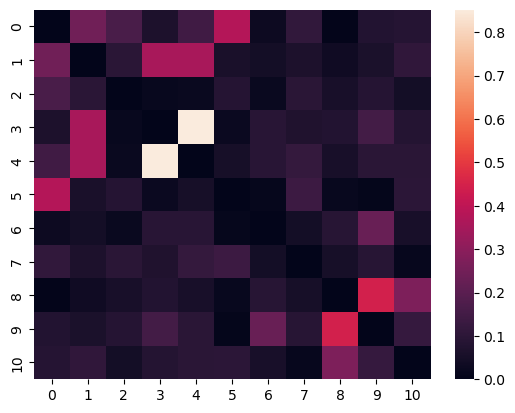

In [5]:
datosCor=datos.drop("G3", axis=1) #Quitamos la variable de salida
cor=abs(np.corrcoef(datosCor,rowvar=False)) #Hacemos la matriz de correlaciones
np.fill_diagonal(cor,0) #Eliminamos los 1 de la diagonal
i,j=np.unravel_index(cor.argmax(),cor.shape) #Ecnontramos la coordenada del dato con mayor correlación
print(i,j) #Imprimimos coordenada
print(cor[i,j]) #Imprimios coeficiente de correlación
from seaborn import heatmap
heatmap(cor) #Generamos heatmap

Hay una alta correlación entre las variables 3 y 4, G1 y G2, por lo que eliminaré G1. 

In [6]:
datos=datos.drop("G1", axis=1) 

5. Incluimos términos de interacción para al menos dos pares de variables, las que  nos llamen más la atención analizar con esta metodología. Elegí comparar MS con G2, para saber si en general se nota una interacción entre la escuela y las calificaciones de los alumnos. También decidí ver la interacción entre la calificación G2 con el internet, para ver si el acceso a internet tiene efecto en la calificación. 

In [7]:
datos.insert(3,"MS G2",datos.MS*datos.G2) #Calculamos interacción multiplicando los datos
datos.insert(7,"G2 yes", datos.G2*datos.yes) #Calculamos interacción
print(datos.head(5)) #Imprimir primeras 5 para comprobar

   Edad  Reprobadas  Faltas  MS G2  G2  G3  MS  G2 yes  M  yes  2  3  4
0    18           0     6.0      0   6   6   0       0  0    0  1  0  0
1    17           0     4.0      0   5   6   0       5  0    1  1  0  0
2    15           3    10.0      0   8  10   0       8  0    1  1  0  0
3    15           0     2.0      0  14  15   0      14  0    1  0  1  0
4    16           0     4.0      0  10  10   0       0  0    0  1  0  0


6. Entrenamos un modelo de regresión lineal múltiple en un subconjunto de datos que corresponda al 80% de los datos totales e imprimimos en consola un resumen de los resultados obtenidos. Posteriormente, usando dicho modelo, predecimos la calificación final del 20% de las observaciones que no se usaron para entrenar. Generamos una gráfica de dispersión de las calificaciones finales reales contra las calificaciones finales estimadas por el modelo en los datos de prueba. 

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     137.3
Date:                Wed, 27 Aug 2025   Prob (F-statistic):          9.29e-115
Time:                        15:30:47   Log-Likelihood:                -640.12
No. Observations:                 316   AIC:                             1306.
Df Residuals:                     303   BIC:                             1355.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8303      1.829      1.001      0.3

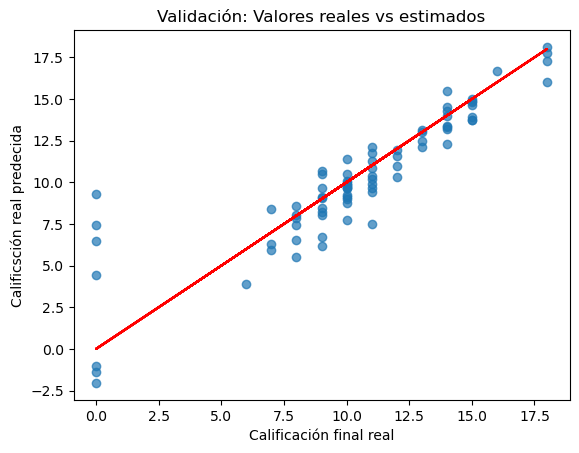

In [8]:
train=datos.sample(frac=.8, random_state=42) #Escogemos los datos de entrenamiento que sean un 80%
test = datos.drop(train.index) #Drop o soltamos los datos previamente escogidos para el entrenamiento
x_train=train.drop("G3", axis=1) #Separamos las variables
y_train=train["G3"] # G3 como la variable de salida
x_test=test.drop("G3", axis=1) #Separamos las variables
y_test=test["G3"] #Definimos G3 como la variable de salida
import statsmodels.api as sm
modelo=sm.OLS(y_train, sm.add_constant(x_train))
resultados=modelo.fit()
print(resultados.summary())
y_hat_test=resultados.predict(sm.add_constant(x_test))
import matplotlib.pyplot as plt
%matplotlib inline
# Gráfica de dispersión: valores reales vs estimados
plt.scatter(y_test, y_hat_test, alpha=0.7)
plt.plot(y_test, y_test, color='red', label='y = x') #Grafico linea perfecta
plt.xlabel("Calificación final real")
plt.ylabel("Calificsción real predecida")
plt.title("Validación: Valores reales vs estimados")
plt.show()

En conclusión, el modelo presenta una R2 de 0.845, la cual podemos decir que es bastante buena, lo que puedo notar es que muchas de las calificaciones reales o son 0, por lo que es donde vemos mayor discrepancia en el modelo. Una buena medida podría ser excluir alumnos con 0, porque puede ser que tengan sus datos, más no estén activamente en la escuela. Las variables que si son significativas por su valor P son calificación en G2 y faltas, lo cual hace sentido con lógica.  